# Thunderstruck
## Low-res spinup

In [1]:
from dataclasses import dataclass, field

import cmocean
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import spatial_mean, time_mean, toa_net_energy, last_n_day_mean
from aeolus.coord import get_cube_rel_days, roll_cube_pm180
from aeolus.core import AtmoSim
from aeolus.io import save_cubelist, create_dummy_cube
from aeolus.model import um
from aeolus.plot import (
    all_sim_file_label,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    hcross,
    subplot_label_generator,
    tex2cf_units,
    timeseries_1d,
)
from matplotlib.offsetbox import AnchoredText
from tqdm.notebook import tqdm

In [2]:
from common import GROUPS, KW_LINE_MARKERS, LOWRES, SIMULATIONS

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
show_sim = [*SIMULATIONS.keys()]

In [6]:
dset = {}
for sim_label in tqdm(show_sim):
    dset[sim_label] = AtmoSim(
        iris.load(
            paths.data
            / "raw"
            / "spinup"
            / SIMULATIONS[sim_label].lowres_spinup_suite
            / "base"
            / LOWRES
            / "umglaa.pa*"
        ),
        name=sim_label,
        planet="trap1e",  # TODO
        model=um,
    )

  0%|          | 0/14 [00:00<?, ?it/s]

In [7]:
lons = dset[sim_label].coord.x.points
lats = dset[sim_label].coord.y.points
# heights = dset[sim_label].coord.z.points

coord_mappings = {
    "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
    "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    # "level_height": dict(ticks=np.arange(0, 41, 5), units="km"),
}

## Maps

In [11]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda AS: roll_cube_pm180(last_n_day_mean(AS.t_sfc, 2400)),
        title="Surface Temperature",
        units="$K$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            vmin=180,
            vmax=290,
            rasterized=True,
        ),
        fmt="auto",
    ),
}

Saved to ../figures/drafts/thunderstruck__n96__all__t_sfc__tm.png
Size: 403.7 KB


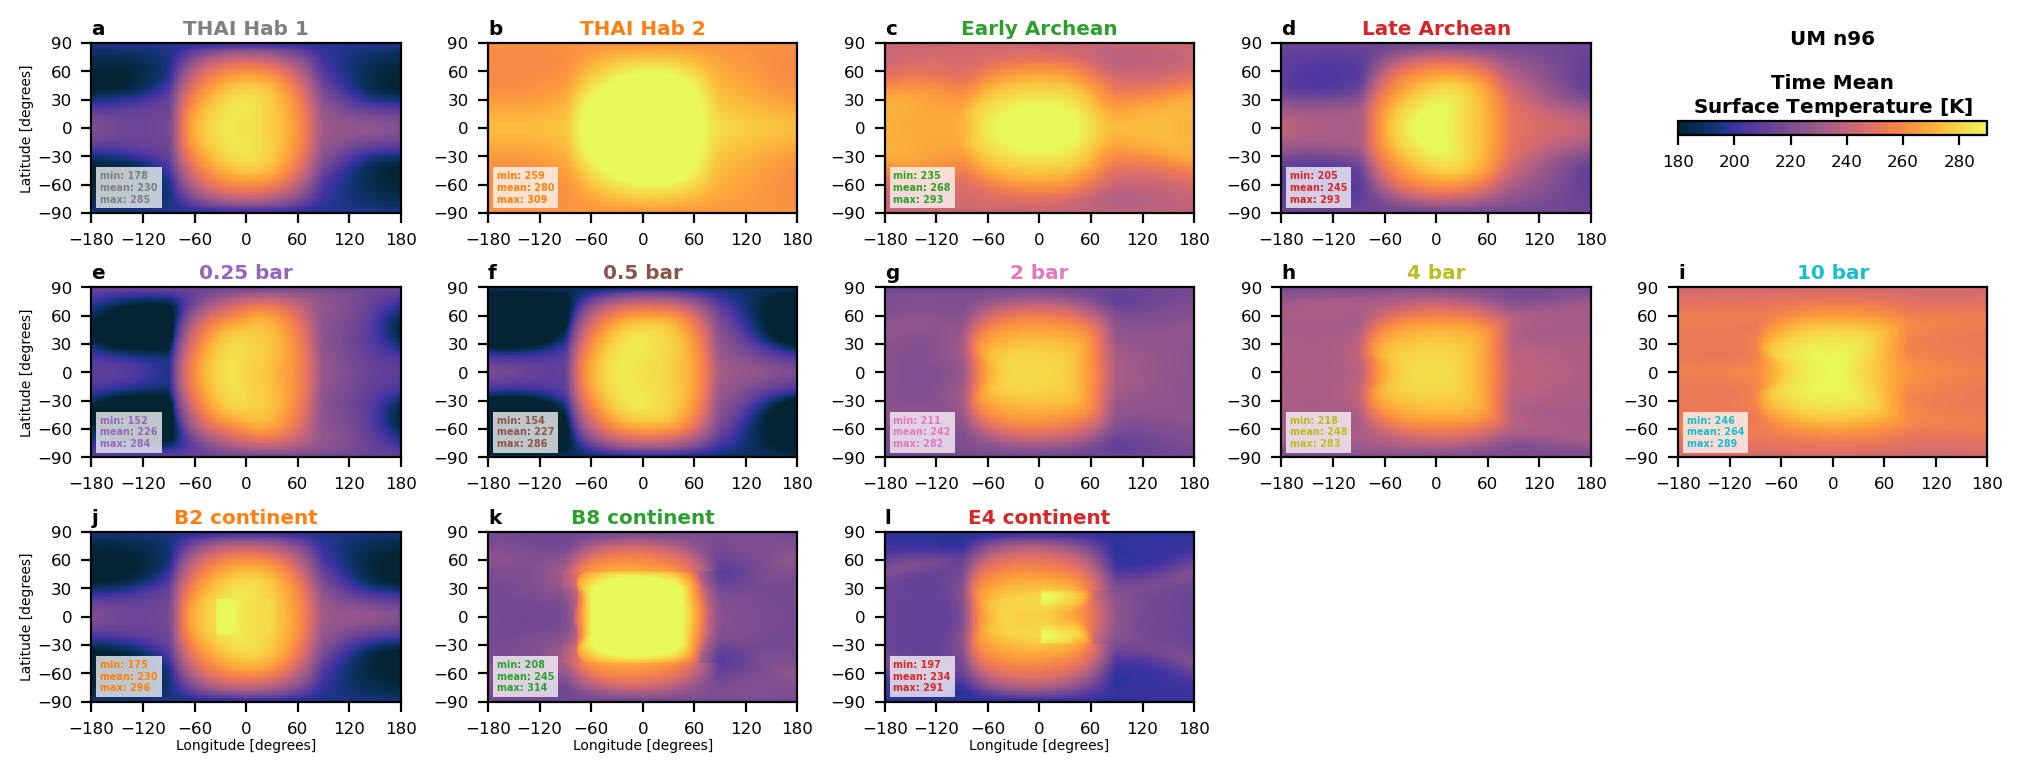

In [14]:
diag_key = "t_sfc"
ttl = f"UM {LOWRES}\n\nTime Mean\n{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]"

fig = plt.figure(figsize=(10, 1.25 * len(GROUPS)), layout="constrained")
# fig.suptitle(ttl)

mosaic = [
    [*GROUPS["comp"].simulations] + ["cax"],
    [i for i in GROUPS["pres"].simulations if i != "hab1_1bar"],
    [i for i in GROUPS["surf"].simulations if i != "hab1_aqua"] + ["."]*2,
]
axd = fig.subplot_mosaic(mosaic)  # , gridspec_kw={"hspace": 0.4}

iletters = subplot_label_generator()
for group in GROUPS.keys():
    for sim_label in GROUPS[group].simulations:
        if sim_label in ["hab1_1bar", "hab1_aqua"]:
            continue  # skip duplicate
        ax = axd[sim_label]
        ax.set_title(f"{next(iletters)}", loc="left")
        ax.set_title(
            SIMULATIONS[sim_label].title,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )

        cube = DIAGS[diag_key].recipe(dset[sim_label])
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        y, x = cube.dim_coords
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )
        h = getattr(ax, DIAGS[diag_key].method)(
            x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt
        )
        if (
            iris.util.guess_coord_axis(x) == "X"
            and iris.util.guess_coord_axis(y) == "Y"
        ):
            at = AnchoredText(
                cube_minmeanmax_str(
                    cube,
                    fmt=DIAGS[diag_key].fmt,
                    precision=1,
                    sep="\n",
                    eq_sign=": ",
                ),
                loc="lower left",
                frameon=True,
                prop={
                    "size": "xx-small",
                    "weight": "bold",
                    "color": SIMULATIONS[sim_label].kw_plt["color"],
                },
            )
            at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
legend_ax = axd["cax"]
legend_ax.set_aspect(5)
cbar = fig.colorbar(h, cax=legend_ax, orientation="horizontal")
legend_ax.set_title(ttl)

figsave(
    fig,
    paths.figures / "drafts" / f"thunderstruck__{LOWRES}__all__{diag_key}__tm",
)

## Time series

In [15]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda AS: spatial_mean(AS.t_sfc),
        title="Surface Temperature",
        units="$K$",
    ),
    "toa_net": Diag(
        recipe=lambda AS: spatial_mean(AS.toa_net_energy),
        title="TOA Net Downward Energy",
        units="$W$ $m^{-2}$",
    ),
    "p_sfc": Diag(
        recipe=lambda AS: spatial_mean(AS.p_sfc),
        title="Surface Pressure",
        units="$bar$",
    ),
}

Saved to ../figures/drafts/thunderstruck__n96__all__t_sfc__gm.png
Size: 168.2 KB
Saved to ../figures/drafts/thunderstruck__n96__all__toa_net__gm.png
Size: 117.5 KB
Saved to ../figures/drafts/thunderstruck__n96__all__p_sfc__gm.png
Size: 55.3 KB


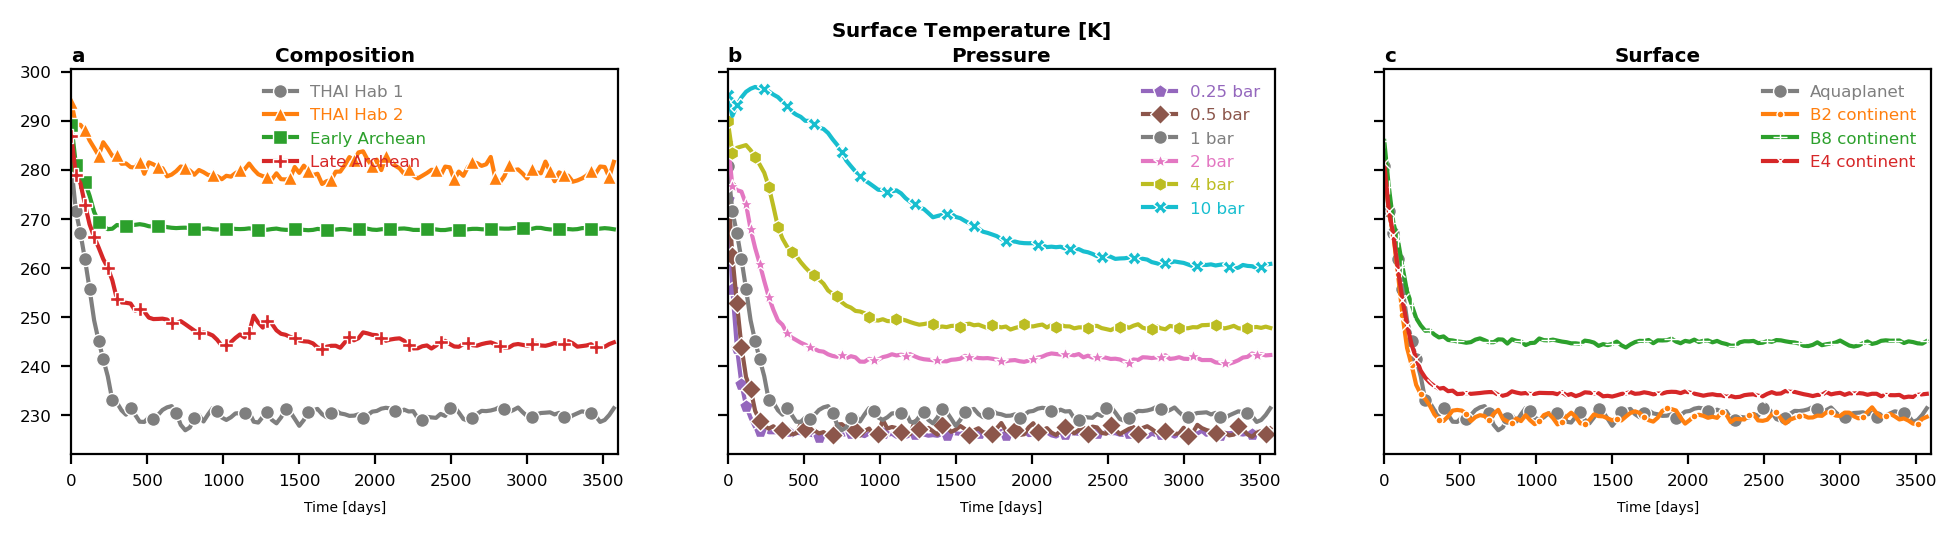

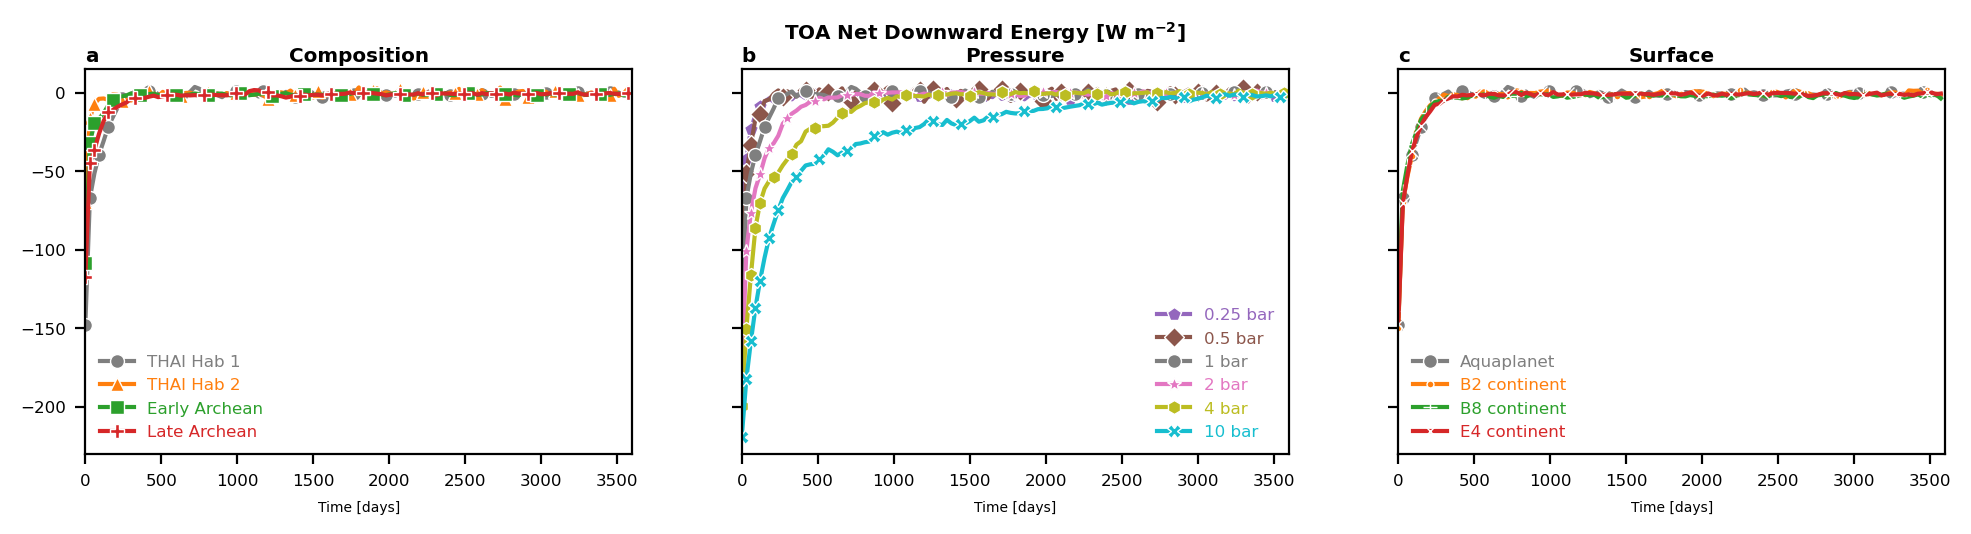

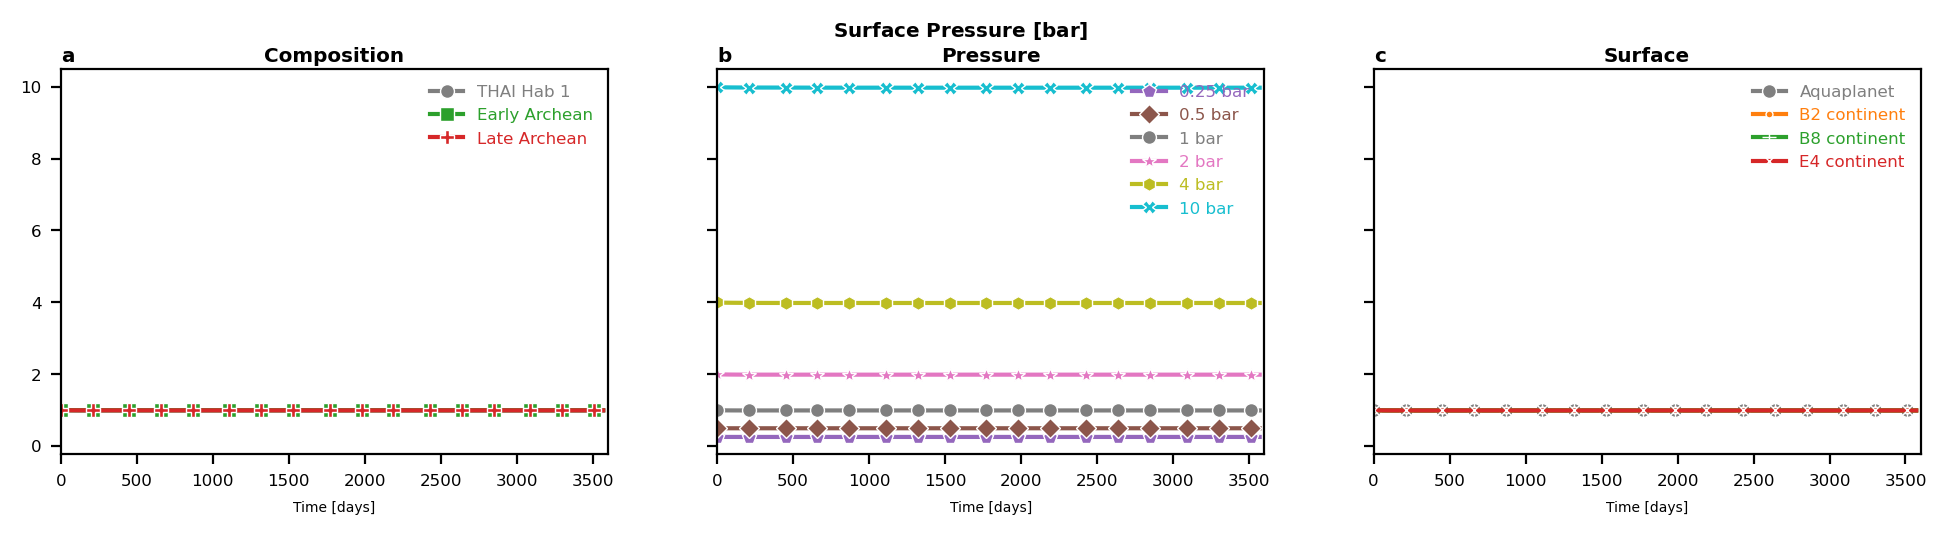

In [16]:
for diag_key in DIAGS.keys():

    fig = plt.figure(figsize=(4 * len(GROUPS), 2.5))
    fig.suptitle(f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]")

    axd = fig.subplot_mosaic([[*GROUPS.keys()]], sharey=True)

    iletters = subplot_label_generator()
    for group in GROUPS.keys():
        for sim_label in GROUPS[group].simulations:
            try:
                cube = DIAGS[diag_key].recipe(dset[sim_label])
                cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
                timeseries_1d(
                    cube,
                    ax=axd[group],
                    label=SIMULATIONS[sim_label].title,
                    **KW_LINE_MARKERS,
                    **SIMULATIONS[sim_label].kw_plt,
                )
            except AttributeError:
                pass
        axd[group].set_xlabel("Time [days]")
        axd[group].set_title(
            GROUPS[group].title,
        )
        axd[group].set_title(
            f"{next(iletters)}",
            loc="left",
        )
        axd[group].legend(frameon=False)
        axd[group].set_xlim(0, 3600)
    figsave(
        fig,
        paths.figures / "drafts" / f"thunderstruck__{LOWRES}__all__{diag_key}__gm",
    )

## Save time mean data

In [61]:
GLOBAL_ATTRIBUTES = {
    "coverage_content_type": "modelResult",
    "creator_email": "d.sergeev@exeter.ac.uk",
    "creator_institution": "University of Exeter",
    "creator_name": "Denis Sergeev",
    "name": "hab2",
    "planet": "hab2",
    "processed": "True",
    "project": "Exascale Exoplanet Modelling",
    "source": "Data from Met Office Unified Model",
    "summary": "Time averaged total surface precipitation flux.",
    "timestep": "300",
    "um_version": "12.2",
    "Conventions": "CF-1.7",
}

In [38]:
cube = last_n_day_mean(dset[sim_label]._cubes.extract_cube("precipitation_flux"), 2400)
cube = roll_cube_pm180(cube)

In [48]:
cube_144x90 = create_dummy_cube(90, 144, pm180=True)
cube_144x90.coord(um.x).coord_system = cube.coord_system()
cube_144x90.coord(um.y).coord_system = cube.coord_system()

In [51]:
cube = cube.regrid(cube_144x90, iris.analysis.Linear())

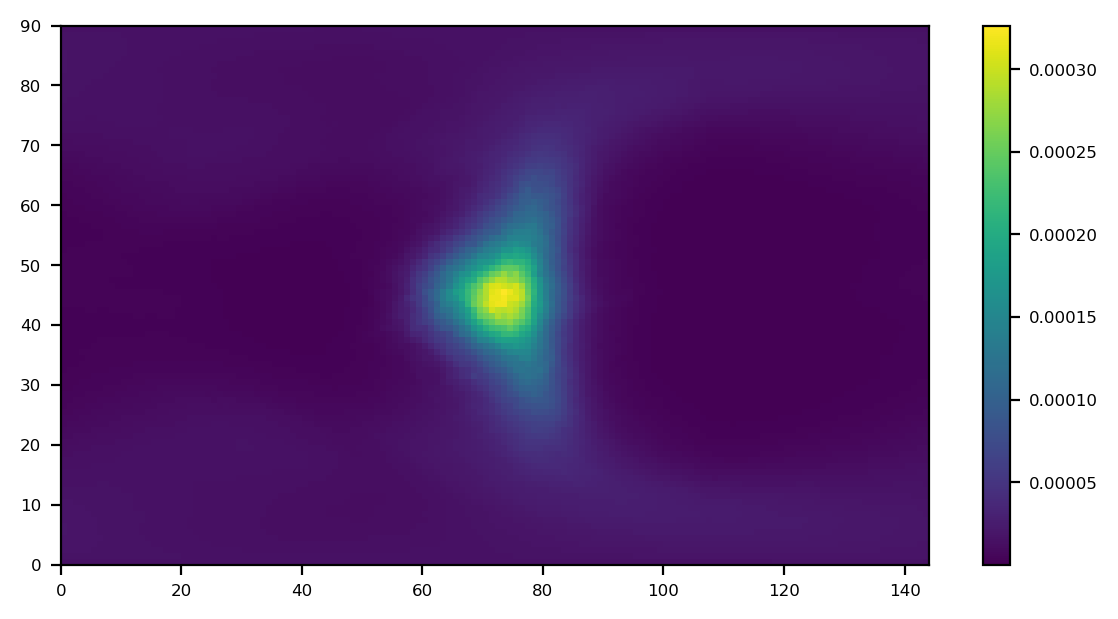

In [52]:
plt.pcolormesh(cube.data)
plt.colorbar()

In [58]:
outdir = paths.data / "proc" / "spinup" / SIMULATIONS[sim_label].lowres_spinup_suite
outdir.mkdir(parents=True, exist_ok=True)

In [68]:
save_cubelist(
    iris.cube.CubeList([cube]),
    outdir / f"thai_{sim_label}_um_precip_time_mean.nc",
    **GLOBAL_ATTRIBUTES,
)